In [70]:
import json
import pandas as pd
import plotly.express as px
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import unicodedata

In [71]:
# Función para normalizar nombres de canciones (quita espacios extra y pasa a minúsculas)
def normalize(song):
    song = song.strip().lower()
    song = ''.join(c for c in unicodedata.normalize('NFKD', song) if not unicodedata.combining(c) or c == 'ñ')
    return song

# Cargar los archivos JSON
with open(r'C:\Users\Yo\Desktop\setlist\SetlistFM-Setlist-Evolution\album_data\Los Piojos.json', 'r', encoding='utf-8') as f:
    albums_data = json.load(f)

with open('piojos.json', 'r', encoding='utf-8') as f:
    setlists_data = json.load(f)

# Crear diccionarios para mapear cada canción a su álbum y a su color
song_to_album = {}
song_to_color = {}
for album in albums_data.get("albums", []):
    album_title = album.get("title", "Ineditos")
    color = album.get("color", "gray")
    for track in album.get("tracks", []):
        norm_track = normalize(track)
        # Si la canción aparece en varios álbumes, se asigna el primero encontrado
        if norm_track not in song_to_album:
            song_to_album[norm_track] = album_title
            song_to_color[norm_track] = color

# Crear un diccionario que mapea cada álbum a su color en formato HEX
album_to_color = {}
for album in albums_data.get("albums", []):
    album_to_color[album.get("title", "Ineditos")] = album.get("color", "#39df00")


# Ordenar los setlists por fecha (usando year, month, day)
setlists_data.sort(key=lambda s: date(s["year"], s["month"], s["day"]))

# Procesar cada setlist y contar acumulativamente
records = []
cumulative_counts = {}

for setlist in setlists_data:
    # Crear fecha en formato ISO
    current_date = date(setlist["year"], setlist["month"], setlist["day"]).isoformat()
    
    # Procesar la lista de canciones, separando por "/" si es necesario
    canciones_raw = setlist.get("songs", [])
    canciones = []
    for item in canciones_raw:
        for part in item.split('/'):
            if part.strip():
                canciones.append(part.strip())
    
    # Actualizar los conteos acumulados
    for song in canciones:
        norm_song = normalize(song)
        cumulative_counts[norm_song] = cumulative_counts.get(norm_song, 0) + 1
    # Registrar el estado acumulado hasta la fecha actual
    for song, count in cumulative_counts.items():
        album = song_to_album.get(song, "Ineditos")
        color = song_to_color.get(song, "#000000")
        records.append({
            "fecha": current_date,
            "canción": song.title(),  # Capitalizamos para visualización
            "álbum": album,
            "color": color,
            "veces_tocada": count,

        })

# Crear DataFrame y agrupar para quedarnos con el último conteo de cada fecha
df = pd.DataFrame(records)


# Diccionario de colores corregido
colores_album = {
    "Ay Ay Ay": "#c41616",
    "3er Arco": "#ead936",
    "Chac Tu Chac": "#1e2830",
    "Azul": "#0047a5",
    "Verde Paisaje del Infierno": "#648e5c",
    "Maquina de Sangre": "#d57f5c",
    "Civilizacion": "#d7c391",
    "Ineditos": "#b3b3b3"
}

# Reemplazar los valores incorrectos en la columna 'color'
df["color"] = df["álbum"].map(colores_album)
df["álbum"] = df["álbum"].astype("category")

# Crear un DataFrame con todas las canciones en la fecha inicial con 0 reproducciones
fecha_inicio = df["fecha"].min()
df_inicio = df.copy()
df_inicio["fecha"] = fecha_inicio  # Asigna la fecha inicial
df_inicio["veces_tocada"] = 0      # Todas las canciones con 0

# Concatenamos con el DataFrame original
df_final = pd.concat([df_inicio, df], ignore_index=True)


In [72]:
top_27_canciones = df_final.groupby("canción")["veces_tocada"].max().nlargest(27).index
df_top = df_final[df_final["canción"].isin(top_27_canciones)]
# Ordenamos los datos para una animación progresiva
df_top = df_top.sort_values(by=["fecha", "veces_tocada"], ascending=[True, False])

# Cargar la fuente desde el archivo directamente
fuente_path = r"C:\Users\Yo\AppData\Local\Microsoft\Windows\Fonts\Los_Piojos.ttf"
fuente_prop = fm.FontProperties(fname=fuente_path)

fechas_unicas = df_top["fecha"].unique()

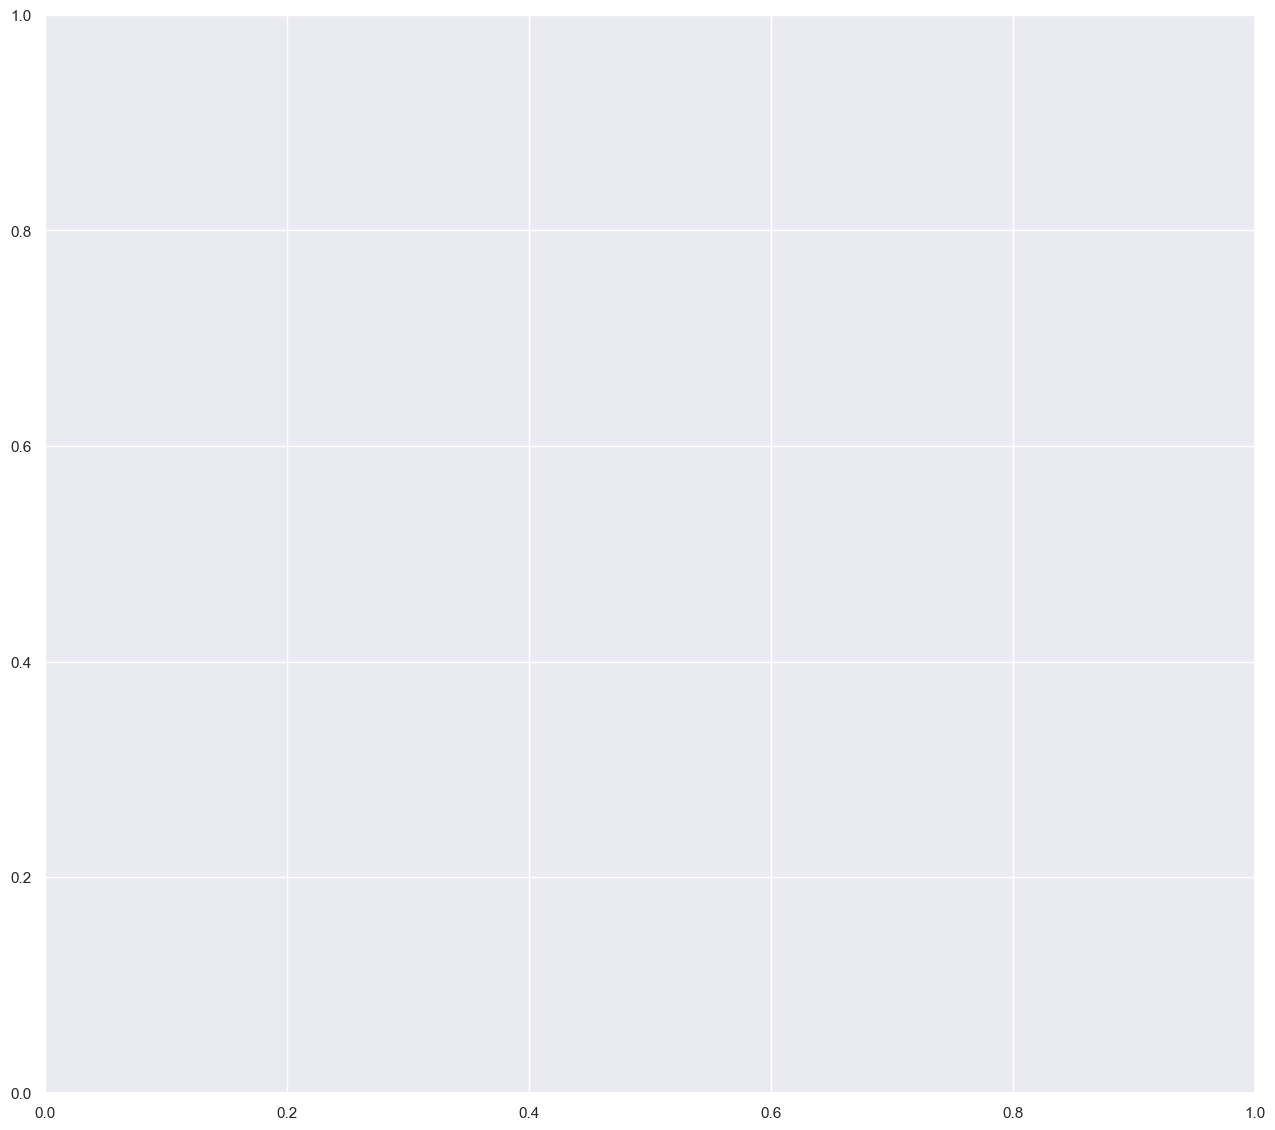

In [ ]:
# Configurar el gráfico
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(22, 14))
plt.subplots_adjust(left=0.25, right=0.8)  # Aumenté el margen izquierdo


# Función de animación
def update(frame):
    fecha_actual = fechas_unicas[frame]
    df_temp = df_final[df_final["fecha"] <= fecha_actual]
    
    df_grouped = df_temp.groupby("canción").agg({
        'veces_tocada': 'last',
        'álbum': 'last'
    }).reset_index()    
    df_grouped = df_grouped.sort_values("veces_tocada", ascending=False).head(27)
    df_grouped = df_grouped.sort_values("veces_tocada", ascending=False)

    ax.clear()    
    colores = [colores_album[album] for album in df_grouped["álbum"]]
    
    ax.barh(df_grouped["canción"][::-1], df_grouped["veces_tocada"][::-1], color=colores[::-1])

    ax.set_xlim(0, df_grouped["veces_tocada"].max() * 1.1)
    ax.set_xlabel("Veces Tocada", fontsize=24, fontproperties=fuente_prop)
    ax.set_ylabel("Cancion", fontsize=24, fontproperties=fuente_prop)
    title_font = fm.FontProperties(fname=fuente_path, size=36)

    ax.set_title(f"Top 27 Canciones mas tocadas en vivo por Los Piojos ({fecha_actual})", fontproperties = title_font, loc = 'center', y = 1.05)
    
    ax.tick_params(axis='both', labelsize = 24)

    ticks_font = fm.FontProperties(fname=fuente_path, size=18)

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
        
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    

        # Añadir recuadro al gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor("black")  # Color del borde
        spine.set_linewidth(2)  # Grosor del borde

    
    # Crear leyenda con los álbumes y sus colores
    handles = [plt.Rectangle((0, 0), 1, 1, color=colores_album[album]) for album in colores_album]
    labels = list(colores_album.keys())

    legend_font = fm.FontProperties(fname=fuente_path, size=18)  # Usa la misma fuente del título

    ax.legend(
    handles, 
    labels, 
    title="Álbum",
    loc='center left', 
    bbox_to_anchor=(1, 0.5),  # Mueve la leyenda fuera del gráfico
    prop=legend_font, 
    frameon=True,  # Activa el recuadro
    edgecolor='black',  # Borde negro
    framealpha=1  # Hace que el fondo del recuadro sea sólido
    )
# Crear animación
ani = FuncAnimation(fig, update, frames=len(fechas_unicas), interval=300, repeat=False)

plt.show()

ani.save("prueba.gif", writer="pillow", fps=10)


In [ ]:
import numpy as np

# Función de interpolación para suavizar transiciones
def interpolar_valores(df_actual, df_siguiente, steps=10):
    """
    Genera valores intermedios entre dos dataframes para hacer la animación más suave.
    """
    interpolated_frames = []

    for i in range(steps):
        alpha = i / steps
        df_interpolated = df_actual.copy()
        df_interpolated["veces_tocada"] = (1 - alpha) * df_actual["veces_tocada"] + alpha * df_siguiente["veces_tocada"]
        interpolated_frames.append(df_interpolated)

    return interpolated_frames

# Función de animación
def update(frame):
    fecha_actual = fechas_unicas[frame]
    df_temp = df_final[df_final["fecha"] <= fecha_actual]
    
    df_grouped = df_temp.groupby("canción").agg({
        'veces_tocada': 'last',
        'álbum': 'last'
    }).reset_index()    
    df_grouped = df_grouped.sort_values("veces_tocada", ascending=False).head(27)
    
    ax.clear()    
    colores = [colores_album[album] for album in df_grouped["álbum"]]

    # Interpolación si no es el último frame
    if frame < len(fechas_unicas) - 1:
        df_siguiente = df_final[df_final["fecha"] <= fechas_unicas[frame + 1]].groupby("canción").agg({
            'veces_tocada': 'last',
            'álbum': 'last'
        }).reset_index().sort_values("veces_tocada", ascending=False).head(27)

        interpolated_frames = interpolar_valores(df_grouped, df_siguiente, steps=10)

        for interpolated_df in interpolated_frames:
            ax.clear()
            colores = [colores_album[album] for album in interpolated_df["álbum"]]
            ax.barh(interpolated_df["canción"][::-1], interpolated_df["veces_tocada"][::-1], color=colores[::-1])
            ax.set_xlim(0, df_grouped["veces_tocada"].max() * 1.1)
            ax.set_xlabel("Veces Tocada", fontsize=24, fontproperties=fuente_prop)
            ax.set_ylabel("Canción", fontsize=24, fontproperties=fuente_prop)
            title_font = fm.FontProperties(fname=fuente_path, size=36)
            ax.set_title(f"Top 27 Canciones más tocadas en vivo por Los Piojos ({fecha_actual})", fontproperties=title_font, loc='center', y=1.05)
            ax.tick_params(axis='both', labelsize=24)

            ticks_font = fm.FontProperties(fname=fuente_path, size=18)
            for label in ax.get_xticklabels():
                label.set_fontproperties(ticks_font)
            for label in ax.get_yticklabels():
                label.set_fontproperties(ticks_font)

            # Añadir recuadro al gráfico
            for spine in ax.spines.values():
                spine.set_edgecolor("black")
                spine.set_linewidth(2)

            # Crear leyenda con los álbumes y sus colores
            handles = [plt.Rectangle((0, 0), 1, 1, color=colores_album[album]) for album in colores_album]
            labels = list(colores_album.keys())

            legend_font = fm.FontProperties(fname=fuente_path, size=18)

            ax.legend(
                handles, labels, title="Álbum", fontsize=16, title_fontsize=18,
                loc='center left', bbox_to_anchor=(1, 0.5), prop=legend_font,
                frameon=True, edgecolor='black', framealpha=1
            )

            plt.pause(0.02)  # Pequeña pausa para hacer la transición más fluida
    else:
        # Último frame sin interpolación
        ax.barh(df_grouped["canción"][::-1], df_grouped["veces_tocada"][::-1], color=colores[::-1])
        ax.set_xlim(0, df_grouped["veces_tocada"].max() * 1.1)
        ax.set_xlabel("Veces Tocada", fontsize=24, fontproperties=fuente_prop)
        ax.set_ylabel("Canción", fontsize=24, fontproperties=fuente_prop)
        title_font = fm.FontProperties(fname=fuente_path, size=36)
        ax.set_title(f"Top 27 Canciones más tocadas en vivo por Los Piojos ({fecha_actual})", fontproperties=title_font, loc='center', y=1.05)
        ax.tick_params(axis='both', labelsize=18)

        ticks_font = fm.FontProperties(fname=fuente_path, size=18)
        for label in ax.get_xticklabels():
            label.set_fontproperties(ticks_font)
        for label in ax.get_yticklabels():
            label.set_fontproperties(ticks_font)

        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(2)

        handles = [plt.Rectangle((0, 0), 1, 1, color=colores_album[album]) for album in colores_album]
        labels = list(colores_album.keys())

        legend_font = fm.FontProperties(fname=fuente_path, size=18)

        ax.legend(
        handles, 
        labels, 
        title="Album", 
        loc='center left', 
        bbox_to_anchor=(1, 0.5),  # Mueve la leyenda fuera del gráfico
        prop=legend_font, 
        frameon=True,  # Activa el recuadro
        edgecolor='black',  # Borde negro
        framealpha=1  # Hace que el fondo del recuadro sea sólido
        )

# Crear animación
ani = FuncAnimation(fig, update, frames=len(fechas_unicas), interval=300, repeat=False)

plt.show()

ani.save("prueba_piola.gif", writer="pillow", fps=10)

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.animation import FuncAnimation

# Función de animación con interpolación
valores_previos = {}

def update(frame):
    global valores_previos
    fecha_actual = fechas_unicas[frame]
    df_temp = df_final[df_final["fecha"] <= fecha_actual]
    
    df_grouped = df_temp.groupby("canción").agg({
        'veces_tocada': 'last',
        'álbum': 'last'
    }).reset_index()    
    df_grouped = df_grouped.sort_values("veces_tocada", ascending=False).head(27)
    df_grouped = df_grouped.sort_values("veces_tocada", ascending=False)

    canciones = df_grouped["canción"].tolist()
    valores_actuales = df_grouped["veces_tocada"].tolist()
    
    # Interpolación suave
    for i, cancion in enumerate(canciones):
        if cancion in valores_previos:
            valores_actuales[i] = np.interp(0.2, [0, 1], [valores_previos[cancion], valores_actuales[i]])
    
    valores_previos = dict(zip(canciones, valores_actuales))
    
    ax.clear()    
    colores = [colores_album[album] for album in df_grouped["álbum"]]
    
    ax.barh(df_grouped["canción"][::-1], valores_actuales[::-1], color=colores[::-1], alpha=0.8)
    
    ax.set_xlim(0, max(valores_actuales) * 1.1)
    ax.set_xlabel("Veces Tocada", fontsize=24, fontproperties=fuente_prop)
    ax.set_ylabel("Cancion", fontsize=24, fontproperties=fuente_prop)
    title_font = fm.FontProperties(fname=fuente_path, size=36)
    
    ax.set_title(f"Top 27 Canciones más tocadas en vivo por Los Piojos ({fecha_actual})", 
                 fontproperties=title_font, loc='center', y=1.05)
    
    ax.tick_params(axis='both', labelsize=18)
    
    ticks_font = fm.FontProperties(fname=fuente_path, size=18)
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    # Añadir recuadro al gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(2)

        handles = [plt.Rectangle((0, 0), 1, 1, color=colores_album[album]) for album in colores_album]
        labels = list(colores_album.keys())

        legend_font = fm.FontProperties(fname=fuente_path, size=18)

        ax.legend(
        handles, 
        labels, 
        title="Album", 
        loc='center left', 
        bbox_to_anchor=(1, 0.5),  # Mueve la leyenda fuera del gráfico
        prop=legend_font, 
        frameon=True,  # Activa el recuadro
        edgecolor='black',  # Borde negro
        framealpha=1  # Hace que el fondo del recuadro sea sólido
        )

# Crear animación
ani = FuncAnimation(fig, update, frames=len(fechas_unicas), interval=200, repeat=False)

plt.show()

ani.save("prueba_piola2.gif", writer="pillow", fps=10)

    